In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os.path
import os
#plt.rcParams['figure.figsize'] = [15, 3.5]

In [57]:
DATADIR = '/home/rafal/WORK/IMPAN/LocalRegression/results_2d/'

In [122]:
def gen_model(x, a, b, c, d, e):
    return a*x[:, 0] + b*x[:, 1] + c*x[:, 0]**2 + d*x[:, 1]**2 + e*x[:, 0]*x[:, 1]

def draw_heatmaps(df, labels, suptitle, filename_base=None, show=False):
    x = df['x'].to_numpy()
    n_pts = int(np.sqrt(x.shape[0]))
    x_uniq = x[:n_pts]
    fig, axs = plt.subplots(1, len(labels), figsize=(25.0/4.0*len(labels), 4.5), facecolor=(1,1,1))
    fig.subplots_adjust(top=0.85)
    for label, ax in zip(labels, axs):
        mse = df[label].mean()
        z = df[label].to_numpy()
        z = z.reshape(n_pts, n_pts)
        c_ = ax.contourf(x_uniq, x_uniq, z, levels=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(label + f' {mse:.8f}')
        plt.colorbar(c_, ax=ax)
    fig.suptitle(suptitle)
    if filename_base:
        filename_output_png = f'{DATADIR}/processed/{filename_base}.png'
        plt.savefig(filename_output_png, bbox_inches='tight')
        if not show:
            plt.close()

def get_suptitle(n, a, b, c, d, e, eps, X):
    return f'n={n}; {a}*X1 + {b}*X2 + {c}*X1^2 + {d}*X2^2 + {e}*X1X2 + N(0, {eps}); X1, X2 ~ {X}'

def get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X):
    return f'2d_n={n}_a={a:.3f}_b={b:.3f}_c={c:.3f}_d{d:.3f}_e{e:.3f}_eps={eps:.4f}_{substitution_policy}_X{X}'

def get_bmr_params(filename_base, method='BMR1'):
    filename_input_pickle = f'{DATADIR}/raw/{method}_{filename_base}.pickle'
    dat = pickle.load(open(filename_input_pickle, 'rb'))
    return dat[0]['epsilon'], dat[0]['min_n_pts']

def get_cut_df(df, xmin, xmax):
    return df[(df['x'] >= xmin) & (df['x'] <= xmax) & (df['y'] >= xmin) & (df['y'] <= xmax)]

def get_mean_mse(df):
    return df[['LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE']].mean()

def fix_column_names(df):
    df.columns = [c.replace('BMR1', 'BMR').replace('BMR2', 'BMR') for c in df.columns]
    return df

def process_df(df, filename_base=None):
    #df = fix_column_names(df)
    df['value'] = gen_model(df[['x', 'y']].to_numpy(), a, b, c, d, e)
    df['slope1'] = a + 2*c*df[['x']].to_numpy() + e*df[['y']].to_numpy()
    df['slope2'] = b + 2*d*df[['y']].to_numpy() + e*df[['x']].to_numpy()
    df['slope1_in_CI'] = [int(x) for x in np.logical_and(df['slope1'] <= df['BMR_beta1_up'], df['slope1'] >= df['BMR_beta1_low'])]
    df['slope2_in_CI'] = [int(x) for x in np.logical_and(df['slope2'] <= df['BMR_beta2_up'], df['slope2'] >= df['BMR_beta2_low'])]
    if filename_base:
        df.to_csv(f'{DATADIR}/processed/{filename_base}.csv')
    return df


def read_csvs(filename_base, methods = ['BMR1', 'LR', 'MARS', 'SVR']):
    if 'BMR1' in methods and 'BMR2' in methods:
        raise ValueError('Cannot process BMR1 and BMR2 at the same time')
    dfs = []
    for index, method in enumerate(methods):
        df = pd.read_csv(f'{DATADIR}/raw/{method}_{filename_base}.csv')
        df = fix_column_names(df)
        if index > 0:
            df = df.drop(['x', 'y'], axis=1)
        dfs.append(df)
    return pd.concat(dfs, axis=1)

In [82]:
n=1000
a=1
b=2
c=0
d=0
e=0.2
eps=0.1
X='U'
substitution_policy='nearest'
suptitle = get_suptitle(n, a, b, c, d, e, eps, X)
filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X)
df = read_csvs(filename_base)
df = process_df(df, filename_base=filename_base)
df_cut = get_cut_df(df, xmin=-3, xmax=3)

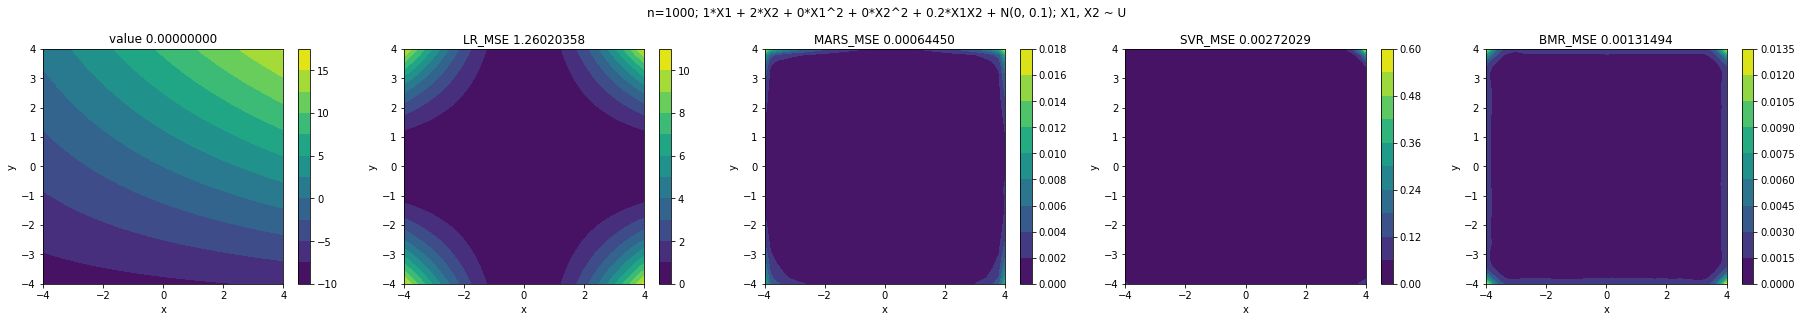

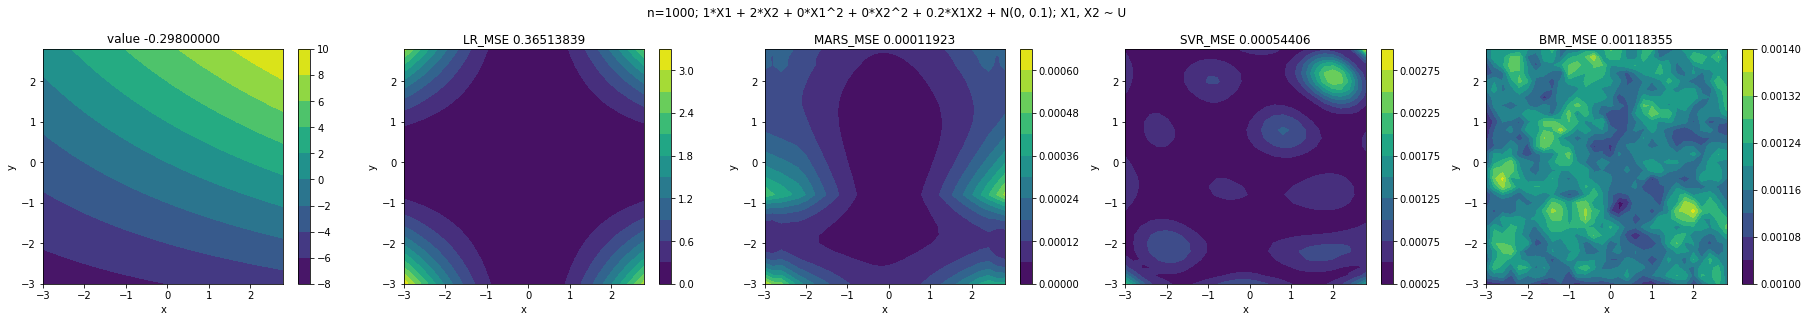

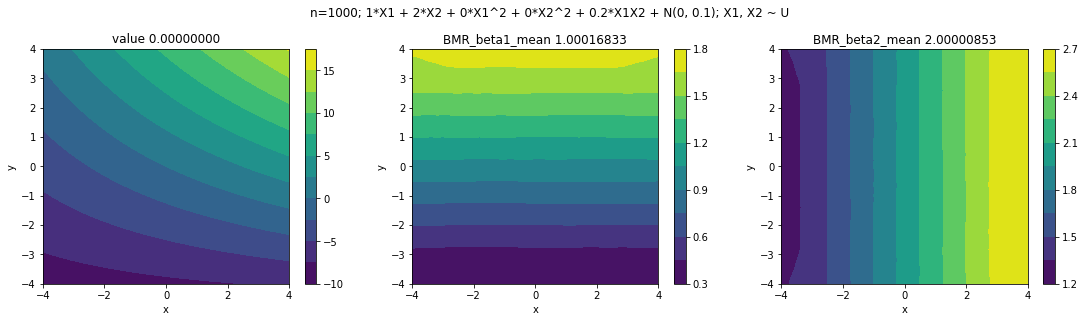

In [84]:
draw_heatmaps(df, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_{filename_base}', show=True)
draw_heatmaps(df_cut, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_cut_{filename_base}', show=True)
draw_heatmaps(df, labels=['value', 'BMR_beta1_mean', 'BMR_beta2_mean'], suptitle=suptitle, filename_base=f'CI_{filename_base}', show=True)

In [125]:
def run_plot(n, a, b, c, d, e, eps, substitution_policy, X):
    mses = []
    mses_cut = []
    filename_base = get_filename_base(n, a, b, c, d, e, eps, substitution_policy, X)
    try:
        df = read_csvs(filename_base, ['BMR2', 'LR', 'MARS', 'SVR'])
        df = process_df(df, filename_base=filename_base)
        df_cut = get_cut_df(df, xmin=-3, xmax=3)
        bmr_params = get_bmr_params(filename_base, method='BMR2')
        mse = [n, a, b, c, d, e, eps, X, *get_mean_mse(df), *bmr_params]
        mse_cut = [n, a, b, c, d, e, eps, X, *get_mean_mse(df_cut), *bmr_params]
        suptitle=get_suptitle(n, a, b, c, d, e, eps, X)
        draw_heatmaps(df, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_{filename_base}')
        draw_heatmaps(df_cut, labels=['value', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE'], suptitle=suptitle, filename_base=f'MSE_cut_{filename_base}')
        draw_heatmaps(df, labels=['value', 'BMR_beta1_mean', 'BMR_beta2_mean'], suptitle=suptitle, filename_base=f'CI_{filename_base}')
        return mse, mse_cut
    except:
        print(f'Error in {filename_base}')
        return None, None

In [126]:
ns = [1000]
Xs = ['U', 'N']
epss = [0.01, 0.1, 0.3]
mses = []
mses_cut = []
substitution_policy='nearest'
for n in ns:
    for X in Xs:
        for eps in epss:
            m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0, eps=eps, substitution_policy=substitution_policy, X=X)
            if m1 and m2:
                mses.append(m1); mses_cut.append(m2)
            m1, m2 = run_plot(n, a=1, b=2, c=-1, d=3, e=0, eps=eps, substitution_policy=substitution_policy, X=X)
            if m1 and m2:
                mses.append(m1); mses_cut.append(m2)
            # m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0.2, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:
            #     mses.append(m1); mses_cut.append(m2)
            # m1, m2 = run_plot(n, a=1, b=2, c=0, d=0, e=0.5, eps=eps, substitution_policy=substitution_policy, X=X, degree=degree)
            # if m1 and m2:
            #     mses.append(m1); mses_cut.append(m2)
            m1, m2 = run_plot(n, a=1, b=2, c=-1, d=3, e=0.5, eps=eps, substitution_policy=substitution_policy, X=X)
            if m1 and m2:
                mses.append(m1); mses_cut.append(m2)

Error in 2d_n=1000_a=1.000_b=2.000_c=0.000_d0.000_e0.000_eps=0.0100_nearest_XN


In [127]:
df_mses = pd.DataFrame(mses, columns=['n', 'a', 'b', 'c', 'd', 'e', 'eps', 'X', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE', 'BMR_eps', 'BMR_npts'])
df_mses_cut = pd.DataFrame(mses_cut, columns=['n', 'a', 'b', 'c', 'd', 'e', 'eps', 'X', 'LR_MSE', 'MARS_MSE', 'SVR_MSE', 'BMR_MSE', 'BMR_eps', 'BMR_npts'])

In [105]:
df_mses_cut

,n,a,b,c,d,e,eps,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts
0,500,1,2,0,0,0.0,0.01,U,4.086702e-07,5.183685e-01,5.814320e-07,1.415010e-06,2.00,55
1,500,1,2,-1,3,0.0,0.01,U,9.539062e+01,1.334219e-01,2.876495e-01,2.270057e-01,0.75,4
2,500,1,2,-1,3,0.5,0.01,U,9.779794e+01,1.415669e+00,2.875473e-01,1.847051e-01,0.50,4
3,500,1,2,0,0,0.0,0.10,U,4.086702e-05,5.274919e-01,5.596239e-05,1.427536e-04,2.00,55
4,500,1,2,-1,3,0.0,0.10,U,9.538938e+01,1.324238e-01,2.473844e-01,2.368037e-01,0.75,4
5,500,1,2,-1,3,0.5,0.10,U,9.779669e+01,1.416092e+00,2.461315e-01,2.536897e-01,0.75,4
6,500,1,2,0,0,0.0,0.30,U,3.678032e-04,5.278937e-01,5.998588e-04,3.462716e-03,1.00,24
7,500,1,2,-1,3,0.0,0.30,U,9.538685e+01,1.309615e-01,1.408207e-01,2.755872e-01,0.75,6
8,500,1,2,-1,3,0.5,0.30,U,9.779417e+01,1.420975e+00,1.409027e-01,2.798067e-01,0.75,4
9,500,1,2,0,0,0.0,0.01,N,1.418579e-06,4.499828e-01,2.233364e-06,1.850765e-06,2.00,98


In [128]:
for method in ['LR', 'MARS', 'SVR']:
    df_mses[f'ratio_{method}'] = df_mses[f'{method}_MSE']/df_mses['BMR_MSE']
    df_mses_cut[f'ratio_{method}'] = df_mses_cut[f'{method}_MSE']/df_mses_cut['BMR_MSE']

In [129]:
df1000 = df_mses[df_mses.n > 500]
df1000.sort_values(['n', 'a', 'b', 'c', 'd', 'e', 'X', 'eps'])

,n,a,b,c,d,e,eps,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts,ratio_LR,ratio_MARS,ratio_SVR
9,1000,1,2,-1,3,0.0,0.01,N,3.358013e+02,1.486707e+00,1.111846e+02,9.602505e+01,0.5,4,3.497018,1.548249e-02,1.157871
12,1000,1,2,-1,3,0.0,0.10,N,3.358036e+02,1.440061e+00,1.142007e+02,5.664616e+03,0.5,4,0.059281,2.542203e-04,0.020160
15,1000,1,2,-1,3,0.0,0.30,N,3.358095e+02,1.489945e+00,1.181307e+02,1.767609e+06,0.5,4,0.000190,8.429153e-07,0.000067
1,1000,1,2,-1,3,0.0,0.01,U,2.515934e+02,2.133129e-01,3.946119e-01,7.074745e+00,0.5,4,35.562180,3.015133e-02,0.055778
4,1000,1,2,-1,3,0.0,0.10,U,2.515937e+02,2.154708e-01,3.408860e-01,5.190970e+03,0.5,4,0.048468,4.150877e-05,0.000066
7,1000,1,2,-1,3,0.0,0.30,U,2.515945e+02,2.341536e-01,1.834358e-01,1.684597e+04,0.5,4,0.014935,1.389968e-05,0.000011
10,1000,1,2,-1,3,0.5,0.01,N,3.436701e+02,2.131463e+01,1.164623e+02,5.076436e+03,0.5,4,0.067699,4.198739e-03,0.022942
13,1000,1,2,-1,3,0.5,0.10,N,3.436724e+02,2.176737e+01,1.195275e+02,3.673719e+04,0.5,4,0.009355,5.925160e-04,0.003254
16,1000,1,2,-1,3,0.5,0.30,N,3.436784e+02,2.443464e+01,1.235493e+02,7.534648e+05,0.5,4,0.000456,3.242970e-05,0.000164
2,1000,1,2,-1,3,0.5,0.01,U,2.594645e+02,2.045077e+00,3.945810e-01,4.714509e+00,0.5,4,55.035331,4.337837e-01,0.083695


In [117]:
df1000 = df_mses[df_mses.n > 500]
df1000.sort_values(['n', 'a', 'b', 'c', 'd', 'e', 'X', 'eps'])

,n,a,b,c,d,e,eps,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts,ratio_LR,ratio_MARS,ratio_SVR
27,1000,1,2,-1,3,0.0,0.01,N,3.358013e+02,1.486707e+00,1.111846e+02,21.538710,0.50,4,15.590595,0.069025,5.162082
29,1000,1,2,-1,3,0.0,0.10,N,3.358036e+02,1.440061e+00,1.142007e+02,21.576138,0.50,4,15.563658,0.066743,5.292917
32,1000,1,2,-1,3,0.0,0.30,N,3.358095e+02,1.489945e+00,1.181307e+02,22.986037,0.50,4,14.609282,0.064820,5.139239
19,1000,1,2,-1,3,0.0,0.01,U,2.515934e+02,2.133129e-01,3.946119e-01,0.067092,0.50,4,3749.963418,3.179399,5.881635
22,1000,1,2,-1,3,0.0,0.10,U,2.515937e+02,2.154708e-01,3.408860e-01,0.150143,0.75,4,1675.692697,1.435103,2.270408
25,1000,1,2,-1,3,0.0,0.30,U,2.515945e+02,2.341536e-01,1.834358e-01,0.128107,0.50,4,1963.940503,1.827797,1.431895
28,1000,1,2,-1,3,0.5,0.01,N,3.436701e+02,2.131463e+01,1.164623e+02,22.075548,0.50,4,15.567906,0.965531,5.275627
30,1000,1,2,-1,3,0.5,0.10,N,3.436724e+02,2.176737e+01,1.195275e+02,22.030936,0.50,4,15.599538,0.988037,5.425441
33,1000,1,2,-1,3,0.5,0.30,N,3.436784e+02,2.443464e+01,1.235493e+02,22.973282,0.50,4,14.959917,1.063611,5.377957
20,1000,1,2,-1,3,0.5,0.01,U,2.594645e+02,2.045077e+00,3.945810e-01,0.069336,0.50,4,3742.106267,29.494959,5.690813


In [120]:
df1000_cut = df_mses_cut[df_mses_cut.n > 500]
df1000_cut.sort_values(['n', 'a', 'b', 'c', 'd', 'e', 'X', 'eps'])

,n,a,b,c,d,e,eps,X,LR_MSE,MARS_MSE,SVR_MSE,BMR_MSE,BMR_eps,BMR_npts,ratio_LR,ratio_MARS,ratio_SVR
27,1000,1,2,-1,3,0.0,0.01,N,8.930580e+01,1.732979e-01,2.292494e+00,1.706842e+00,0.50,4,52.322253,0.101531,1.343120
29,1000,1,2,-1,3,0.0,0.10,N,8.930677e+01,1.665327e-01,2.507386e+00,1.744261e+00,0.50,4,51.200353,0.095475,1.437506
32,1000,1,2,-1,3,0.0,0.30,N,8.930932e+01,1.756781e-01,2.852575e+00,2.118829e+00,0.50,4,42.150330,0.082913,1.346298
19,1000,1,2,-1,3,0.0,0.01,U,9.500694e+01,1.754310e-01,2.657156e-01,5.509916e-02,0.50,4,1724.290142,3.183915,4.822497
22,1000,1,2,-1,3,0.0,0.10,U,9.500665e+01,1.773849e-01,2.170953e-01,1.330022e-01,0.75,4,714.323704,1.333698,1.632268
25,1000,1,2,-1,3,0.0,0.30,U,9.500614e+01,1.919901e-01,9.449419e-02,1.177497e-01,0.50,4,806.848325,1.630494,0.802501
28,1000,1,2,-1,3,0.5,0.01,N,9.174089e+01,1.783773e+00,2.470106e+00,1.769005e+00,0.50,4,51.860171,1.008348,1.396325
30,1000,1,2,-1,3,0.5,0.10,N,9.174188e+01,1.800596e+00,2.693158e+00,1.754779e+00,0.50,4,52.281154,1.026110,1.534756
33,1000,1,2,-1,3,0.5,0.30,N,9.174449e+01,1.854985e+00,3.054142e+00,1.956630e+00,0.50,4,46.889035,0.948051,1.560920
20,1000,1,2,-1,3,0.5,0.01,U,9.740167e+01,1.456263e+00,2.681247e-01,5.548359e-02,0.50,4,1755.504079,26.246725,4.832504
